In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df.set_index('date', inplace=True)
tmp_df.head()

pass_acct_dt    0
prest_txn_tm    0
txn_amt         0
dtype: int64


,pass_acct_dt,prest_txn_tm,txn_amt
date,,,
2019-07-13,20190713,10514868,150.0
2019-07-13,20190713,10320728,50.0
2019-07-13,20190713,11170684,-54670.0
2019-07-13,20190713,13415506,-56220.0
2019-07-13,20190713,11202778,50.0


date
2018-01-01      246352.73
2018-01-02    44174467.69
2018-01-03     1229238.64
2018-01-04       40340.18
2018-01-05    55524398.38
Name: txn_amt, dtype: float64

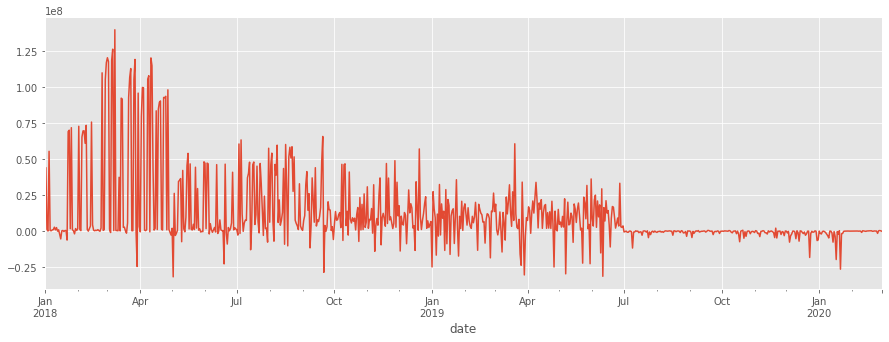

In [75]:
cash_flow_d = tmp_df.groupby(['date'])['txn_amt'].sum()
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
cash_flow_d[:'2020-02-29'].plot()
cash_flow_d.head()

In [65]:
cash_flow_train = cash_flow_d[:'2020-02-29']
cash_flow_train_diff = cash_flow_train.diff(1).fillna(0)

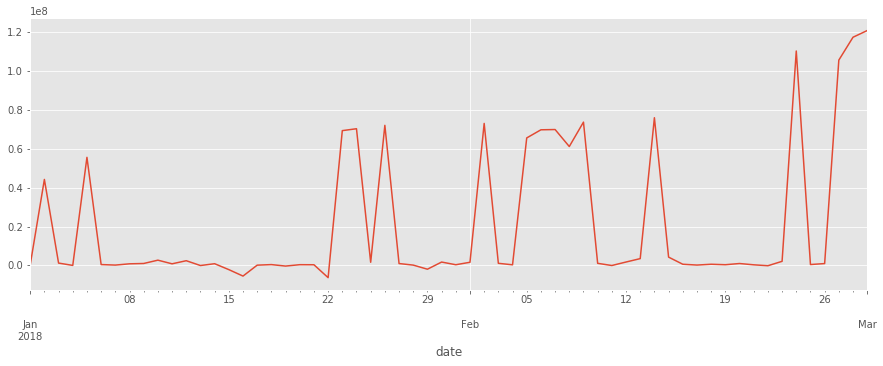

In [74]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
cash_flow_train['2018-01-01':'2018-03-01'].plot()

In [64]:
from statsmodels.tsa.stattools import adfuller as ADF
ADF(cash_flow_d[:'2020-02-29'])

(-1.9837423353531258,
 0.2937466966683647,
 20,
 769,
 {'1%': -3.438882201132452,
  '5%': -2.865305765357574,
  '10%': -2.568775270215655},
 28102.85822916092)

In [66]:
ADF(cash_flow_train_diff)

(-9.737660643367713,
 8.663077214902687e-17,
 21,
 768,
 {'1%': -3.4388933482333464,
  '5%': -2.8653106782623574,
  '10%': -2.5687778874376086},
 28093.606481875257)

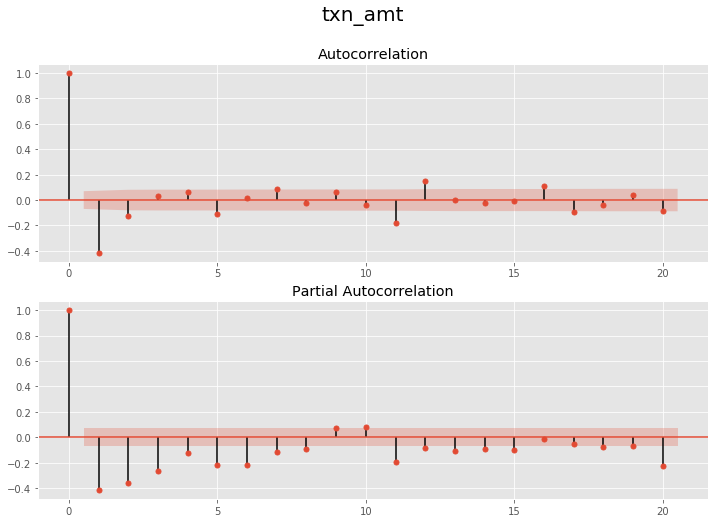

In [70]:
import statsmodels.api as sm

def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
autocorrelation(cash_flow_train_diff, 20)

In [55]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage
count_deposit_ratios(tmp_df, 500000)


total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    2880
prest_txn_tm    2880
txn_amt         2880
dtype: int64, percentage:pass_acct_dt    0.011823
prest_txn_tm    0.011823
txn_amt         0.011823
dtype: float64


pass_acct_dt    0.011823
prest_txn_tm    0.011823
txn_amt         0.011823
dtype: float64

In [56]:
deposit_seq = [5000,10000,50000,100000,500000,1000000]
percentages = []
for deposit in deposit_seq:
    percentages.append(count_deposit_ratios(tmp_df, deposit))

print(percentages)
    

total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    79408
prest_txn_tm    79408
txn_amt         79408
dtype: int64, percentage:pass_acct_dt    0.325978
prest_txn_tm    0.325978
txn_amt         0.325978
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    51371
prest_txn_tm    51371
txn_amt         51371
dtype: int64, percentage:pass_acct_dt    0.210883
prest_txn_tm    0.210883
txn_amt         0.210883
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    20140
prest_txn_tm    20140
txn_amt         20140
dtype: int64, percentage:pass_acct_dt    0.082677
prest_txn_tm    0.082677
txn_amt         0.082677
dtype: float64
total:pass_acct_dt    243599
prest_txn_tm    243599
txn_amt         243599
dtype: int64, count:pass_acct_dt    11660
prest_txn_tm    11660
txn_amt         11660
dtype: int6

In [ ]:
tmp_df

In [35]:
cash_flow_daily = pd.DataFrame(tmp_df.groupby(['date'])['txn_amt'].sum())
cash_flow_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 963 entries, 2018-01-01 to 2020-08-20
Data columns (total 1 columns):
txn_amt    963 non-null float64
dtypes: float64(1)
memory usage: 15.0 KB


In [36]:
cash_flow_daily.tail()

,txn_amt
date,
2020-08-16,12619.27
2020-08-17,-189570.38
2020-08-18,182505.08
2020-08-19,207034.19
2020-08-20,-86638.55


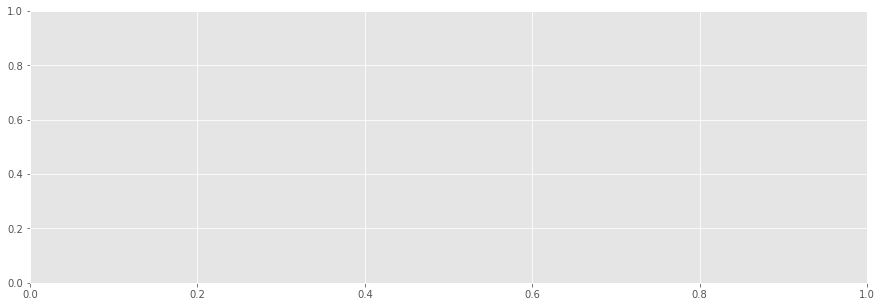

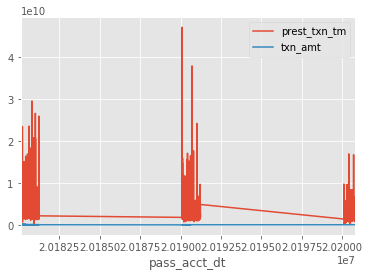

In [16]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15, 5))
cash_flow_daily.plot()
plt.show()


In [4]:
cash_flow_daily.head(20)

,prest_txn_tm,txn_amt
pass_acct_dt,,
20180101,2177907508,246352.73
20180102,4860136319,44174467.69
20180103,3592016709,1229238.64
20180104,3041112843,40340.18
20180105,3293772478,55524398.38
20180106,2662529809,464680.48
20180107,1800502188,203680.59
20180108,10921885639,849726.78
20180109,3595437626,1019996.38
